In [9]:
import sys
print(sys.version)

3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]


In [10]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
!pip install tqdm
!pip install seaborn==0.9.0
!pip install numpy==1.17.3

    100% |████████████████████████████████| 215kB 10.0MB/s ta 0:00:01
  Found existing installation: seaborn 0.8.1
    Uninstalling seaborn-0.8.1:
      Successfully uninstalled seaborn-0.8.1
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 61kB 2.8MB/s ta 0:00:011
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 20.0MB 2.5MB/s eta 0:00:01
  Found existing installation: numpy 1.14.3
    Uninstalling numpy-1.14.3:
      Successfully uninstalled numpy-1.14.3
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from s3fs.core import S3FileSystem
import psutil
import ipywidgets

In [2]:
print(sns.__version__)
print(np.__version__)

0.9.0
1.17.3


## Load Data

In [3]:
s3 = S3FileSystem()
embeddings = pickle.load(s3.open('s3://globo-latent/articles_embeddings.pickle'))
df_sample = pd.read_csv(s3.open('s3://globo-latent/df_sample.csv'))

In [4]:
#memory check
psutil.virtual_memory()

svmem(total=33361264640, available=31880245248, percent=4.4, used=1068032000, free=30736797696, active=1549631488, inactive=805437440, buffers=161067008, cached=1395367936, shared=77824, slab=107941888)

In [5]:
class NonlinearModel():
    def __init__(self, user_data, item_embeddings, size=8, embeddings_size=250, T=1):
        self.user_data = user_data
        self.item_embeddings = item_embeddings
        self.len_ = self.item_embeddings.shape[0]
        self.T = T
        self.Vd = NonlinearModel.d.get_embedding_vectors(
            item_embeddings, user_data, size, embeddings_size=embeddings_size
        )
        self.U = self.initialize_user_vectors(
            size=size,embeddings_size=embeddings_size
        )
        self.n_users = int(self.user_data.shape[0]/size)
        self.reset_errors()
    
    def reset_errors(self):
        self.errors = []
    
    def initialize_user_vectors(self,size,embeddings_size):
        '''
        sets self.U in parent class __init__
        uses clustering methods defined in the Cluster sub-class
        '''
        starting_vectors = NonlinearModel.d.get_embedding_vectors(
            self.item_embeddings,
            self.user_data,
            size,
            embeddings_size=embeddings_size
        )
        
        return NonlinearModel.Cluster.k_means(starting_vectors,self.T)
        #return NonlinearModel.Cluster.starting_centroids(starting_vectors,self.T)
    
    
    class Cluster():
        @staticmethod
        def starting_centroids(points,T):
            '''
            initialize centroids by randomly picking an item for each user
            '''
            starter_idx = np.random.rand(points.shape[0],T).argsort(axis=-1)[:,0:T,np.newaxis]
            return np.take_along_axis(
                points,
                starter_idx,
                axis=1
            )

        @staticmethod
        def closest_centroid(points, centroids):
            '''
            find the closest centroid to each point using euclidean distance
            it's ok to use euclidean distance for now because clustering just gives a starting point
            the model will be optimized further during gradient descent
            '''
            return np.argmin(
                np.square(
                    np.sum(
                        np.square(points[:,:,np.newaxis] - centroids[:,np.newaxis]),
                        axis=3
                    ),
                ),
                axis=2
            )

        @staticmethod
        def move_centroids(points,closest,k):
            '''
            find new centroid based on cluster center from closest_centroid
            '''
            
            
            weights = np.equal(
                np.arange(k)[np.newaxis,:,np.newaxis],
                closest[:,np.newaxis,:]
            )

            weights = np.repeat(weights[:,:,:,np.newaxis],points.shape[2],axis=3)
            
            
            points = np.repeat(points[:,np.newaxis],k,axis=1)

            return np.average(
                points,
                weights = weights,
                axis=2
            )

        @staticmethod
        def k_means(starting_vectors,k):
            '''
            Recursive function to optimize kmeans using the functions above,
            starting_centroids, closest_centroid, and move_centroid
            '''
            def iterative_kmeans(starting_vectors,old_centroids, new_centroids,k):
                while True:
                    if np.all(new_centroids == old_centroids):
                        return new_centroids
                    else:
                        old_centroids = new_centroids
                        new_centroids = NonlinearModel.Cluster.move_centroids(
                            starting_vectors,
                            NonlinearModel.Cluster.closest_centroid(
                                starting_vectors,
                                old_centroids
                                ),                                           
                            k,
                        )
                        iterative_kmeans(starting_vectors,old_centroids,new_centroids,k)
            starting_centroids = NonlinearModel.Cluster.starting_centroids(starting_vectors,k)
            return iterative_kmeans(
                starting_vectors,
                np.zeros(starting_centroids.shape),
                starting_centroids,
                k
            )
    

    #############################
    ###### SEEN AND UNSEEN ######
    #############################
    
    class d:
        @staticmethod
        def get_embedding_vectors(V_embeddings, df, size, embeddings_size=250):
            return np.hstack(V_embeddings[df.click_article_id.to_list()]).reshape(-1,size,embeddings_size)
    
    class dbar:
        @staticmethod
        def get_unseen(df, u, size, len_):
            return np.random.choice(
                np.delete(
                    np.arange(len_),
                    df[df.index.get_level_values(0)==u].click_article_id,
                ),
                size=size,
            )
        
        @staticmethod
        def get_all_unseen(df, size, test_size, len_):            
            #semi-vectorized version
            return df.user_id[0::size].map(
                lambda u: NonlinearModel.dbar.get_unseen(df, u, test_size, len_)
            )
        
        @staticmethod
        def get_embedding_vectors(V_embeddings, df, n_users, size, test_size, embeddings_size=250, len_=36047):
            
            return np.hstack(
                V_embeddings[NonlinearModel.dbar.get_all_unseen(df,size,test_size,len_).tolist()]
            ).reshape(
                n_users,
                -1,
                embeddings_size
            )
    
    #############################
    ###### Gradient Descent #####
    #############################
    
    class gradient():
        @staticmethod
        def argmax_indices(U,Vd):
            '''
            get which interest unit per user, per item, is best for each of their relevant items, d
            output of tensor dot should be 100 x 8 x 3
            output of argmax should be 100 x 8
            '''
            return np.argmax(
                np.tensordot(
                    Vd,
                    U,
                    axes=(2,2)
                )[:,:,0],
                axis=2
            )
        
        @staticmethod
        def argmax_indices_modified(U,Vd,Vdbar):
            return np.argmin(
                np.tensordot(Vdbar,U,axes=(2,2))[:,:,0] - np.tensordot(Vd,U,axes=(2,2))[:,:,0] ,
                axis=2)
        
        @staticmethod
        def dJi(Ui,argmax_indices,Vd,Vdbar,T,hinge_param=1):
            '''
            Note that Ui has only the relevant vector (interest unit), while U has all vectors.
            Steps are outlined below.
            '''
            
            #see if it adds up to more than 0, if it does, it counts toward the cost.
            cond = hinge_param + np.tensordot(Ui,Vdbar,axes=(2,2))[0,0] - np.tensordot(Ui,Vd,axes=(2,2))[0,0] > 0
            
            #gradient
            g = Vdbar - Vd
            
            #multiply the calculated gradient by the condition (true and false translate to 1 and 0)
            partial_gradient = g * cond[:,:,np.newaxis]
            
            #the next part applies the gradient to only the relevant interest unit
            broadcast_gradient=partial_gradient[:,np.newaxis].repeat(T,axis=1)
            
            #boolean matrix tells which interest unit to update
            boolean_matrix = np.equal(argmax_indices[:,np.newaxis],np.arange(T)[np.newaxis,:,np.newaxis])

            return np.sum(broadcast_gradient * boolean_matrix[:,:,:,np.newaxis], axis=2)
        
        
        @staticmethod
        def J(Ui,Vd,Vdbar,hinge_param=1):
            '''
            Total cost calculation. Used if test=True.
            '''
            cost = hinge_param + np.tensordot(Ui,Vdbar,axes=(2,2))[0,0] - np.tensordot(Ui,Vd,axes=(2,2))[0,0]
            return np.sum(
                np.max(
                    [np.zeros((cost.shape[0],cost.shape[1])), cost], axis = 1
                )
            )

        
    def get_Vdbar_test(self,test_size=128,embeddings_size=250):
        '''
        Get Vdbar for gd validation (used if test=True)
        '''
        self.Vdbar_test = NonlinearModel.dbar.get_embedding_vectors(
                self.item_embeddings,
                self.user_data,
                test_size,
                embeddings_size=embeddings_size,
            )
        
        

    def gradient_descent_nonlinear(
        self,
        alpha=0.01,
        size=8,
        batch_size=16,
        test_size=128,
        embeddings_size=250,
        test=True,
        use_vdbar_for_interest_unit=False,
        hinge_param=1,
        max_iterations=500,
        readj_interval=1,
        gd_algorithm = None
    ):
        
        self.reset_errors()
        
        batch_mult = int(batch_size/size)
        
        if gd_algorithm == 'rprop':
            gd_algorithm = np.sign
        else:
            gd_algorithm = lambda x: x
        
        for iteration in tqdm(range(max_iterations)):
            
            #get vdbar for gradient calculation
            Vdbar = NonlinearModel.dbar.get_embedding_vectors(
                self.item_embeddings,
                self.user_data,
                self.n_users,
                size,
                size*batch_mult,
                embeddings_size=embeddings_size,
            )
            
            ##readjustment interval
            if iteration % readj_interval == 0:
                if use_vdbar_for_interest_unit == True:
                    argmax_indices = NonlinearModel.gradient.argmax_indices_modified(self.U,self.Vd,Vdbar)
                else:
                    argmax_indices = NonlinearModel.gradient.argmax_indices(self.U,self.Vd)

            #Ui refers to just the relevant user interest vector. n_users x n_items x m
            Ui = np.take_along_axis(
                self.U,
                argmax_indices[:,:,np.newaxis],
                axis=1
            )

            

            ### UPDATE ###
            self.U = self.U - alpha / batch_mult * gd_algorithm(NonlinearModel.gradient.dJi( 
                Ui.repeat(batch_mult,axis=1), ##
                argmax_indices.repeat(batch_mult,axis=1),
                self.Vd.repeat(batch_mult,axis=1), ##
                Vdbar,
                self.T,
                hinge_param=hinge_param))
            ###############

            if test == True:
                #get Vdbar
                Vdbar_test = NonlinearModel.dbar.get_embedding_vectors(
                    self.item_embeddings,
                    self.user_data,
                    self.n_users,
                    size,
                    test_size,
                    embeddings_size=embeddings_size,
                    len_=self.len_
                )


                #add the error at this step to the list of errors so it can be graphed
                #note that this is with a different Vdbar than the one used to calculate gradient
                self.errors.append(
                    NonlinearModel.gradient.J(Ui,self.Vd.repeat(test_size/size,axis=1),Vdbar_test,hinge_param=1) / test_size
                )

            if iteration == max_iterations - 1:
                if test == True:

                    plt.figure(figsize=(12,8))
                    plt.xlabel('Iterations')
                    sns.lineplot(
                        x = range(len(self.errors)),
                        y = self.errors
                    )
                    plt.show()

                return None
            
            iteration += 1

## Optimization

In [6]:
def optimize(T=3,alpha=0.01,max_iterations=2,batch_size=32,test_size=32,hinge_param=1,readj_interval=1,gd_algorithm=None):
    nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=1)
    start = time()
    nm.gradient_descent_nonlinear(
        test=True,
        alpha=alpha,
        max_iterations=max_iterations,
        batch_size=batch_size,
        test_size=test_size,
        hinge_param = hinge_param,
        readj_interval=readj_interval,
        gd_algorithm=gd_algorithm
    )
    print(time() - start, 'seconds')

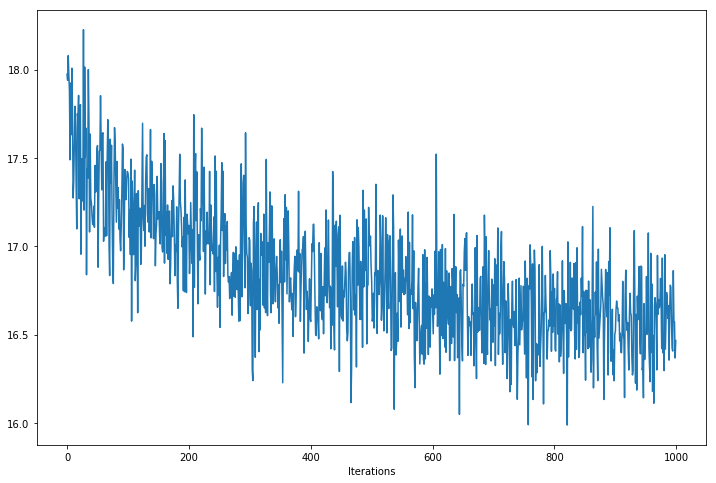

1055.4156699180603 seconds


In [10]:
### 3499.8843202590942 seconds

nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=1)
start = time()
nm.gradient_descent_nonlinear(
    test=True,
    alpha=0.01,
    max_iterations=1000,
    batch_size=32,
    test_size=128,
    hinge_param = 1,
)
print(time() - start, 'seconds')

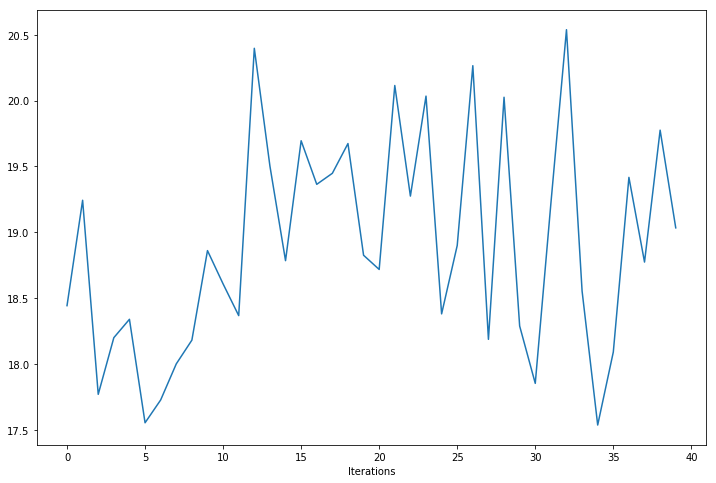

24.2728533744812 seconds


In [23]:
optimize(
    T=3,
    alpha=0.1,
    max_iterations=40,
    batch_size=16,
    test_size=16,
    hinge_param = 5,
)

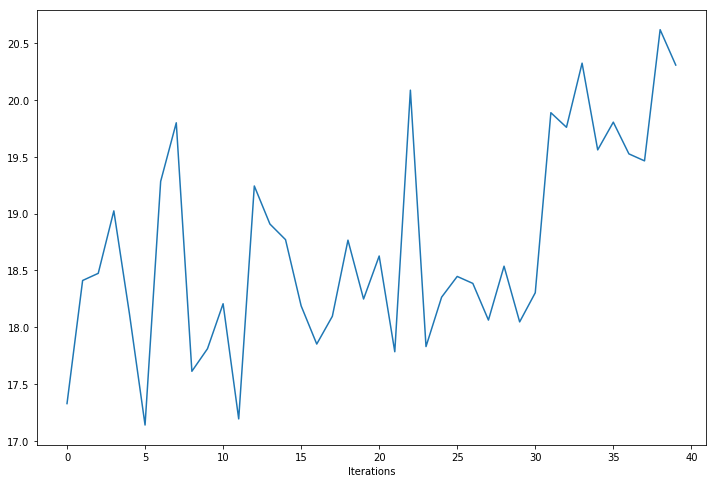

23.753690004348755 seconds


In [24]:
optimize(
    T=3,
    alpha=0.1,
    max_iterations=40,
    batch_size=16,
    test_size=16,
    hinge_param = 5,
    readj_interval=10
)

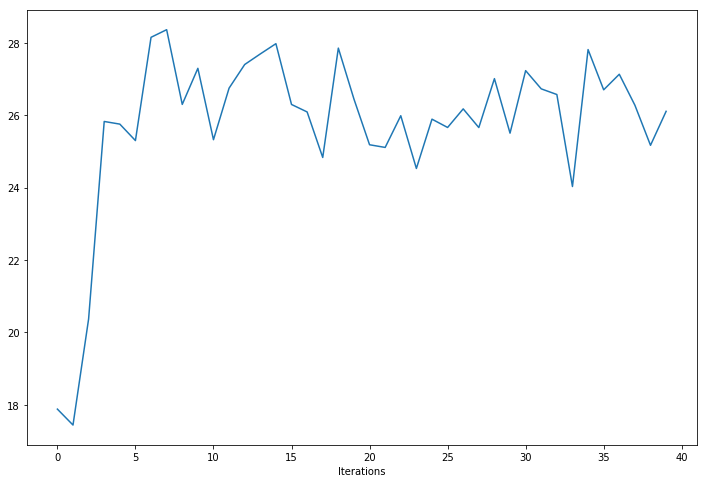

23.68663740158081 seconds


In [25]:
optimize(
    T=3,
    alpha=0.25,
    max_iterations=40,
    batch_size=16,
    test_size=16,
    hinge_param = 5,
    readj_interval=10
)

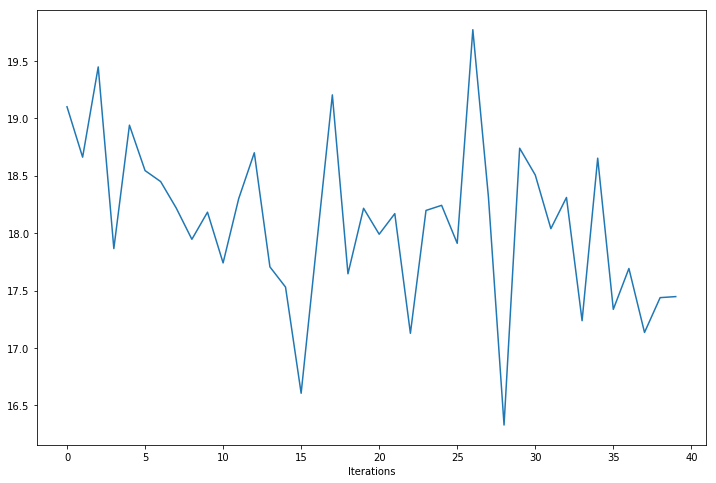

23.823010206222534 seconds


In [27]:
optimize(
    T=3,
    alpha=0.0025,
    max_iterations=40,
    batch_size=16,
    test_size=16,
    hinge_param = 5,
    readj_interval=10
)

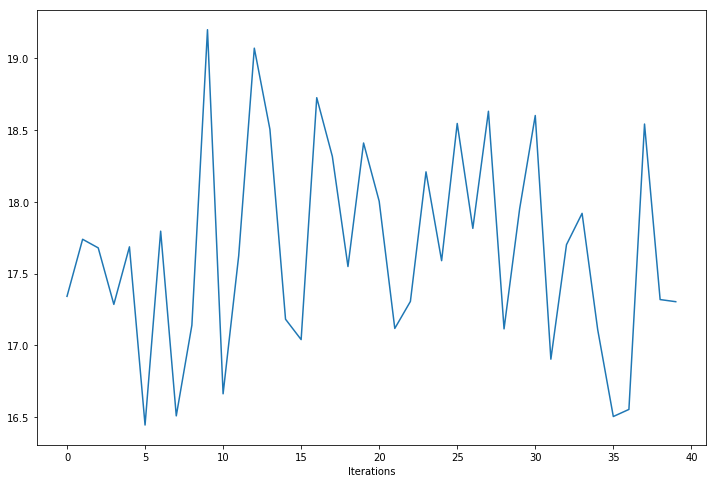

23.619061946868896 seconds


In [28]:
optimize(
    T=3,
    alpha=0.0025,
    max_iterations=40,
    batch_size=16,
    test_size=16,
    hinge_param = 5,
    readj_interval=10
)

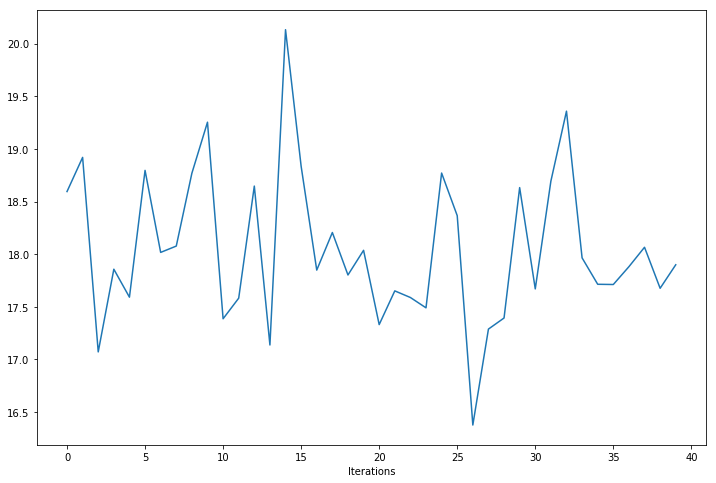

27.957409143447876 seconds


In [29]:
optimize(
    T=3,
    alpha=0.001,
    max_iterations=40,
    batch_size=24,
    test_size=16,
    hinge_param = 5,
    readj_interval=1
)

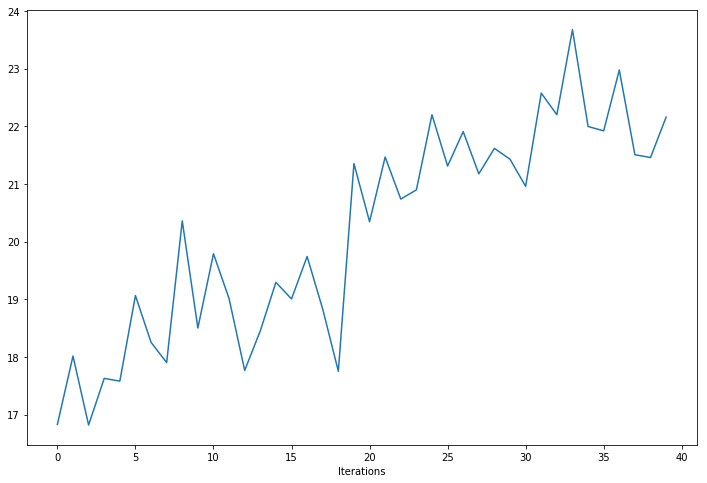

27.495157957077026 seconds


In [30]:
optimize(
    T=3,
    alpha=0.001,
    max_iterations=40,
    batch_size=24,
    test_size=16,
    hinge_param = 25,
    readj_interval=1
)

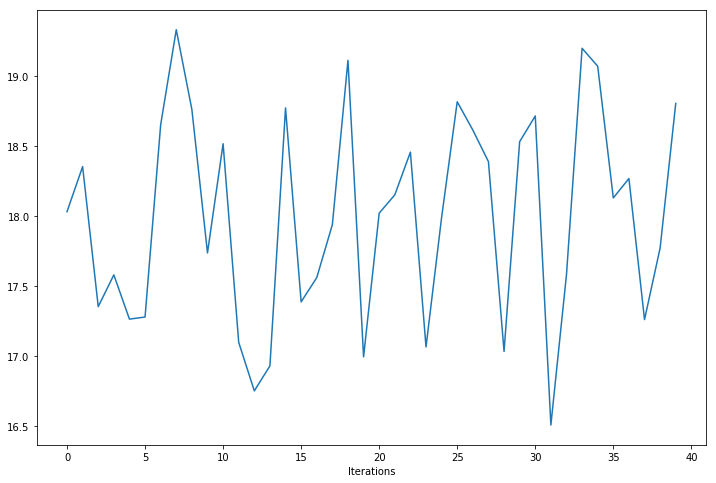

27.370309114456177 seconds


In [31]:
optimize(
    T=3,
    alpha=0.001,
    max_iterations=40,
    batch_size=24,
    test_size=16,
    hinge_param = -25,
    readj_interval=1
)

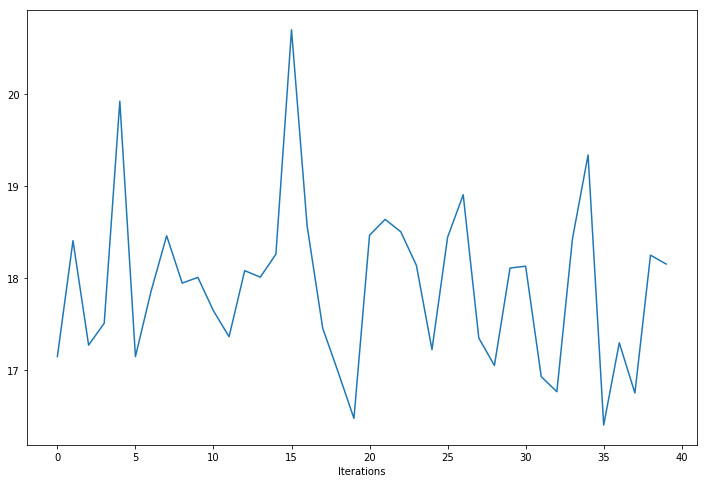

27.45105290412903 seconds


In [32]:
optimize(
    T=3,
    alpha=0.001,
    max_iterations=40,
    batch_size=24,
    test_size=16,
    hinge_param = -1,
    readj_interval=1
)

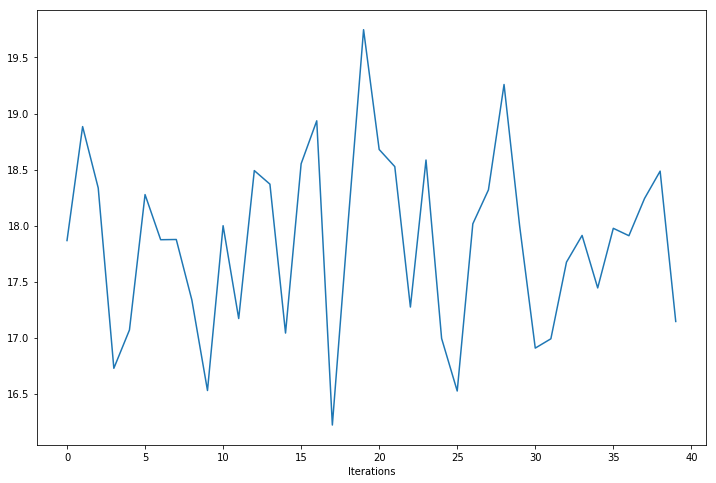

27.418286561965942 seconds


In [33]:
optimize(
    T=3,
    alpha=0.001,
    max_iterations=40,
    batch_size=24,
    test_size=16,
    hinge_param = -3,
    readj_interval=1
)

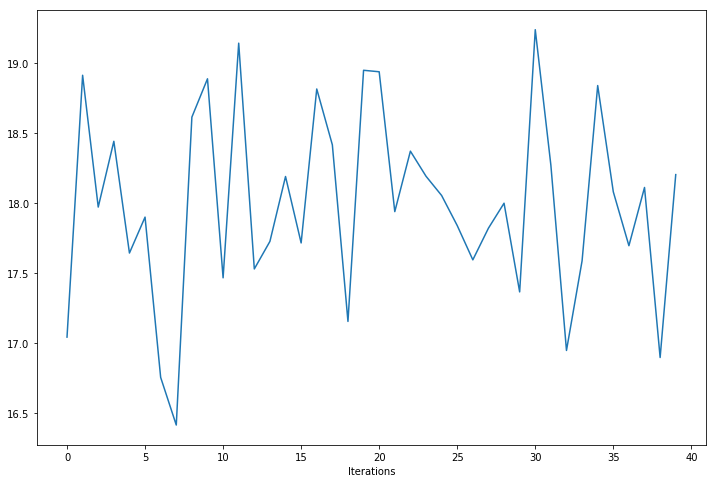

27.413631439208984 seconds


In [34]:
optimize(
    T=3,
    alpha=0.001,
    max_iterations=40,
    batch_size=24,
    test_size=16,
    hinge_param = -3,
    readj_interval=1,
    gd_algorithm='rprop'
)

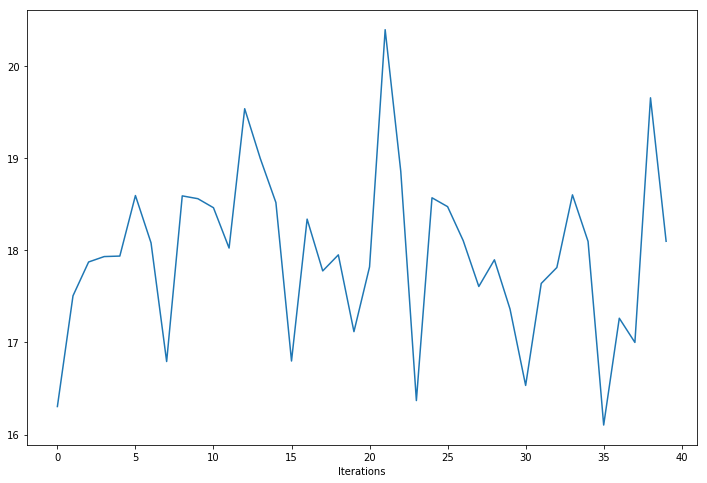

28.02874493598938 seconds


In [35]:
optimize(
    T=3,
    alpha=0.001,
    max_iterations=40,
    batch_size=24,
    test_size=16,
    hinge_param = 3,
    readj_interval=1,
    gd_algorithm='rprop'
)

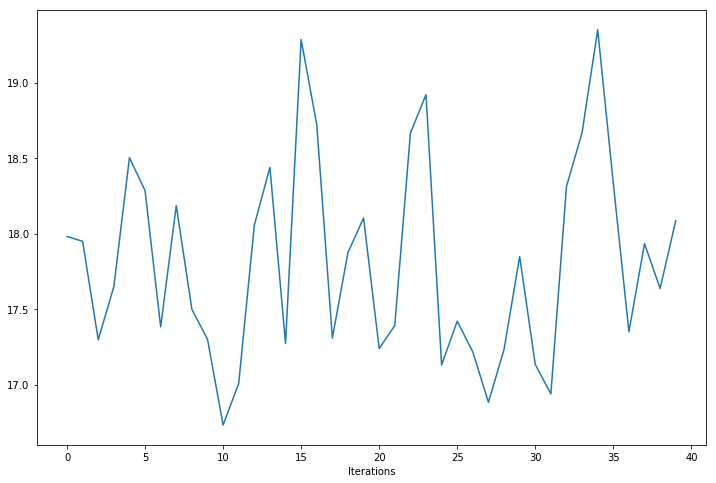

27.683903694152832 seconds


In [36]:
optimize(
    T=3,
    alpha=0.0001,
    max_iterations=40,
    batch_size=24,
    test_size=16,
    hinge_param = 3,
    readj_interval=1,
    gd_algorithm='rprop'
)

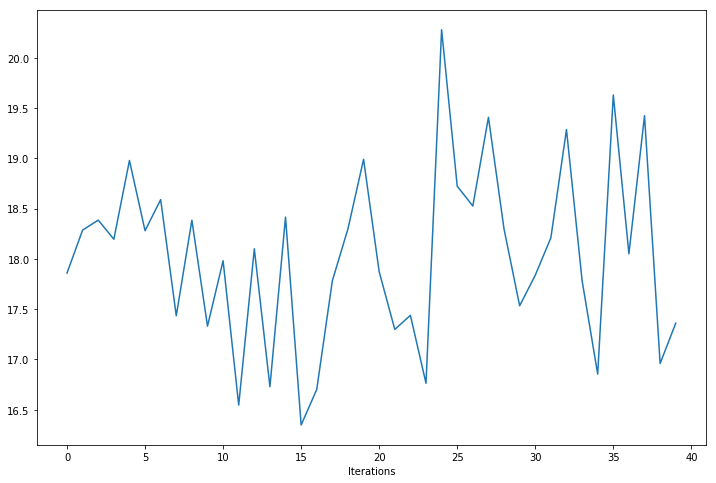

27.658143758773804 seconds


In [37]:
optimize(
    T=3,
    alpha=0.0001,
    max_iterations=40,
    batch_size=24,
    test_size=16,
    hinge_param = 0,
    readj_interval=1,
    gd_algorithm='rprop'
)

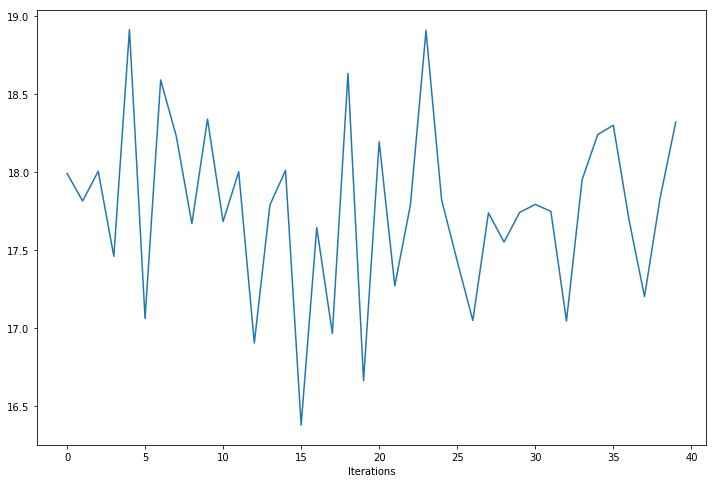

27.199573040008545 seconds


In [38]:
optimize(
    T=3,
    alpha=0.0001,
    max_iterations=40,
    batch_size=24,
    test_size=16,
    hinge_param = 0,
    readj_interval=20,
    gd_algorithm=None
)

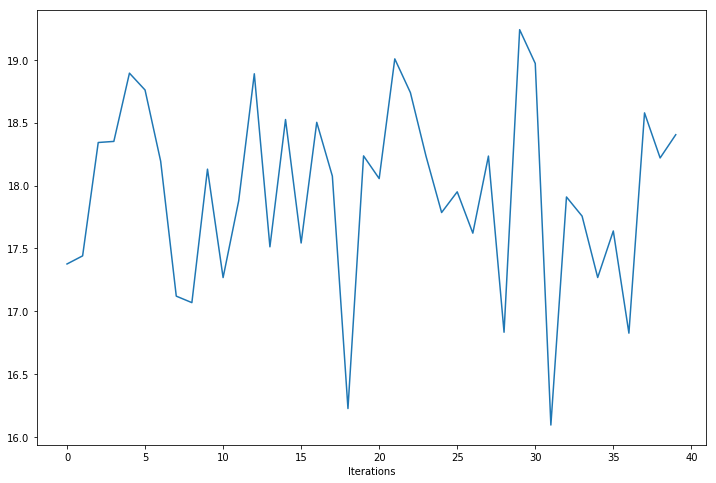

27.007498502731323 seconds


In [39]:
optimize(
    T=3,
    alpha=0.001,
    max_iterations=40,
    batch_size=24,
    test_size=16,
    hinge_param = 5,
    readj_interval=20,
    gd_algorithm=None
)

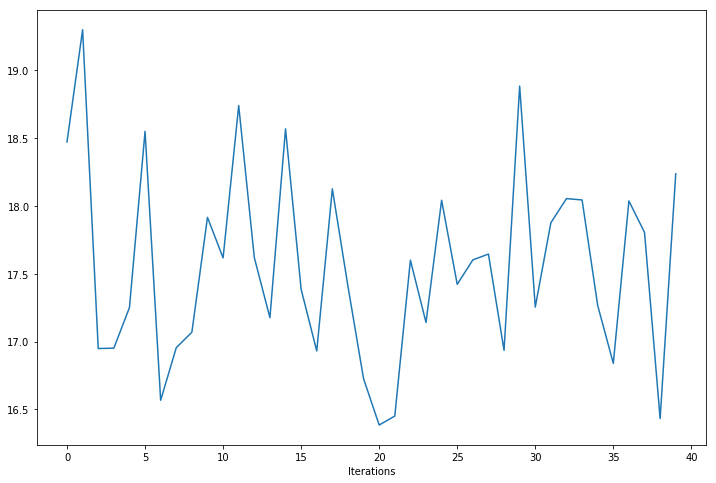

27.082646369934082 seconds


In [40]:
optimize(
    T=3,
    alpha=0.01,
    max_iterations=40,
    batch_size=24,
    test_size=16,
    hinge_param = 0,
    readj_interval=20,
    gd_algorithm=None
)

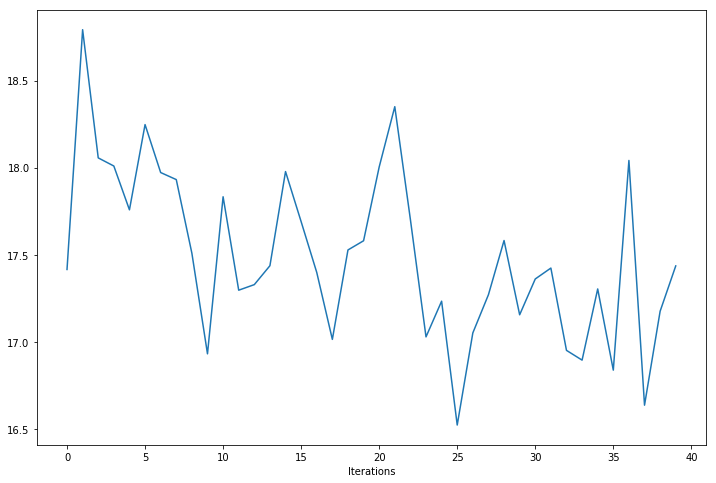

29.037230968475342 seconds


In [41]:
optimize(
    T=3,
    alpha=0.01,
    max_iterations=40,
    batch_size=24,
    test_size=32,
    hinge_param = 0,
    readj_interval=20,
    gd_algorithm=None
)

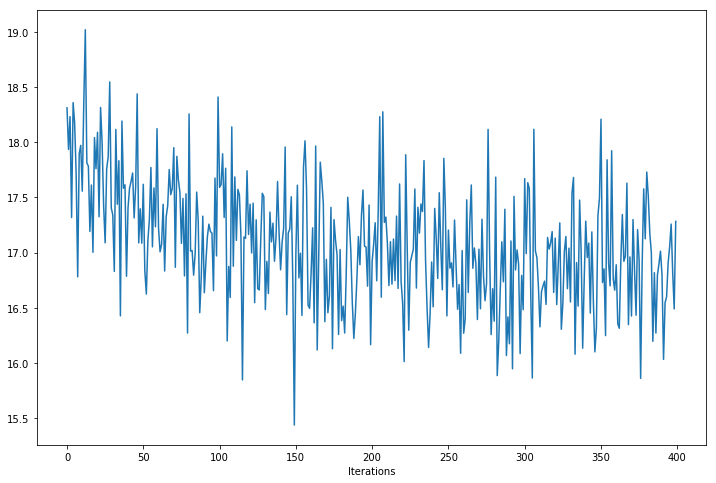

283.5681929588318 seconds


In [42]:
optimize(
    T=3,
    alpha=0.01,
    max_iterations=400,
    batch_size=24,
    test_size=32,
    hinge_param = 0,
    readj_interval=20,
    gd_algorithm=None
)

Alpha: 0.1
Hinge Regularization: -5
Readjustment Interval: 1


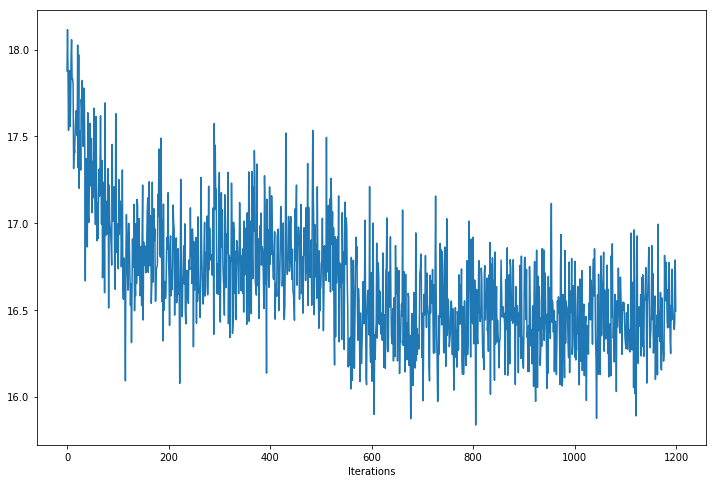

1691.7404088974 seconds
Alpha: 0.1
Hinge Regularization: -5
Readjustment Interval: 10


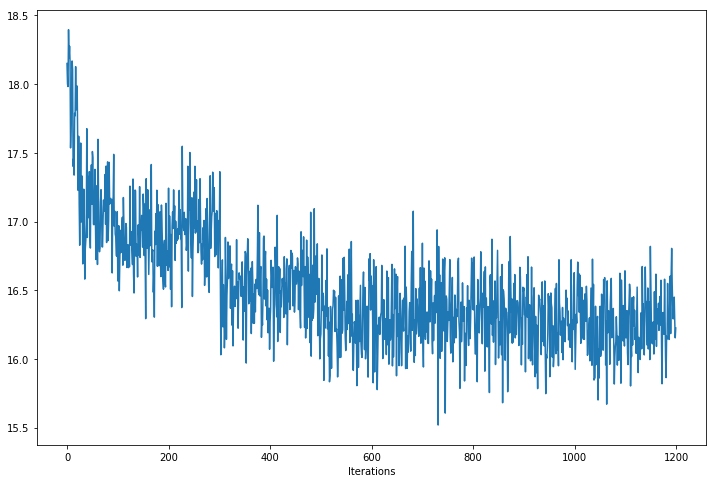

1624.734710931778 seconds
Alpha: 0.1
Hinge Regularization: -5
Readjustment Interval: 20


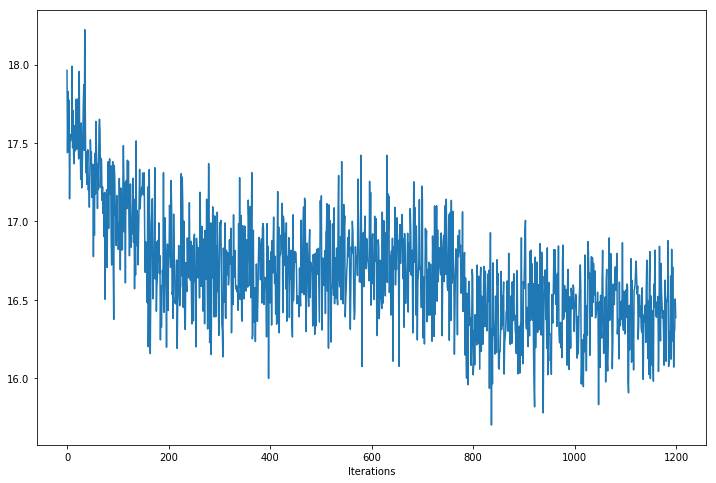

1646.0679731369019 seconds
Alpha: 0.1
Hinge Regularization: -5
Readjustment Interval: 40


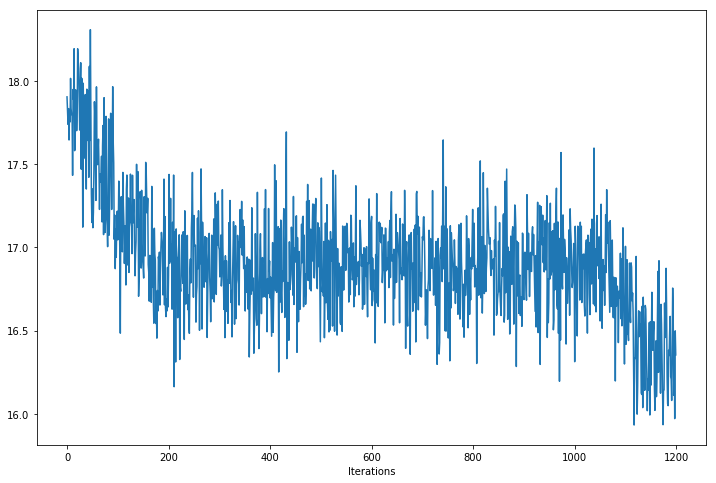

1652.5684974193573 seconds
Alpha: 0.1
Hinge Regularization: -4
Readjustment Interval: 1


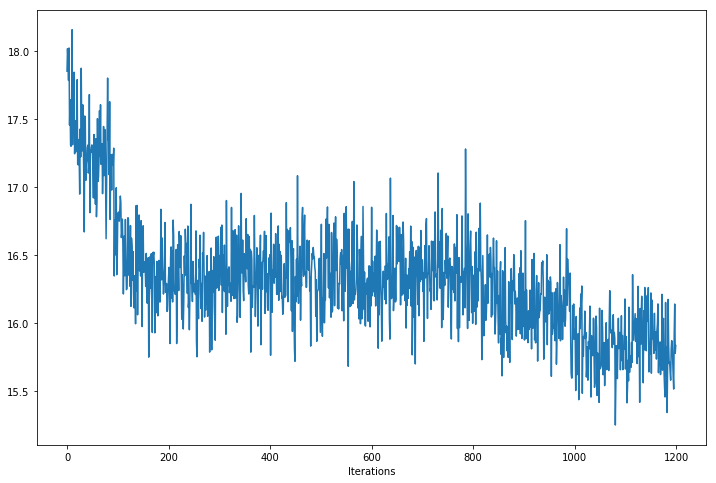

1695.7404615879059 seconds
Alpha: 0.1
Hinge Regularization: -4
Readjustment Interval: 10


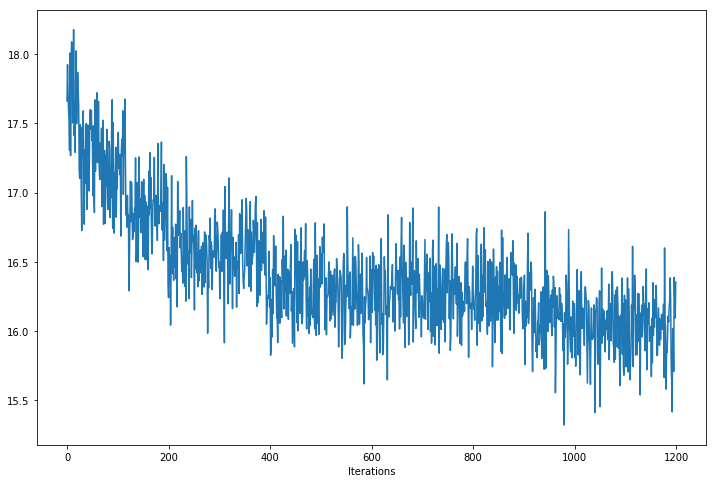

1628.6960380077362 seconds
Alpha: 0.1
Hinge Regularization: -4
Readjustment Interval: 20


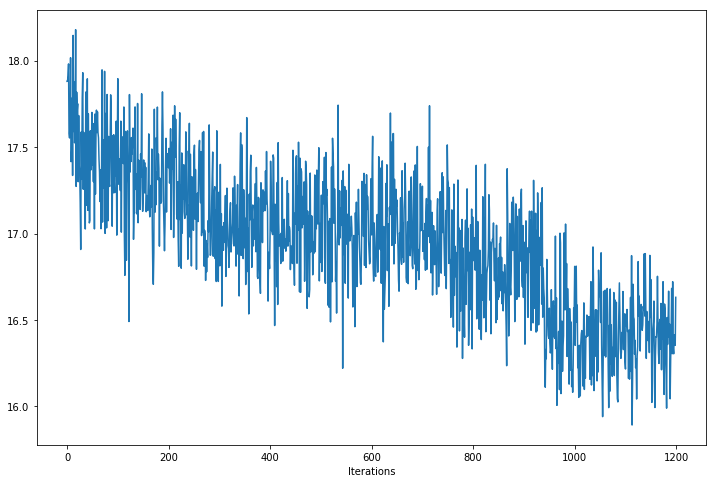

1627.8323233127594 seconds
Alpha: 0.1
Hinge Regularization: -4
Readjustment Interval: 40


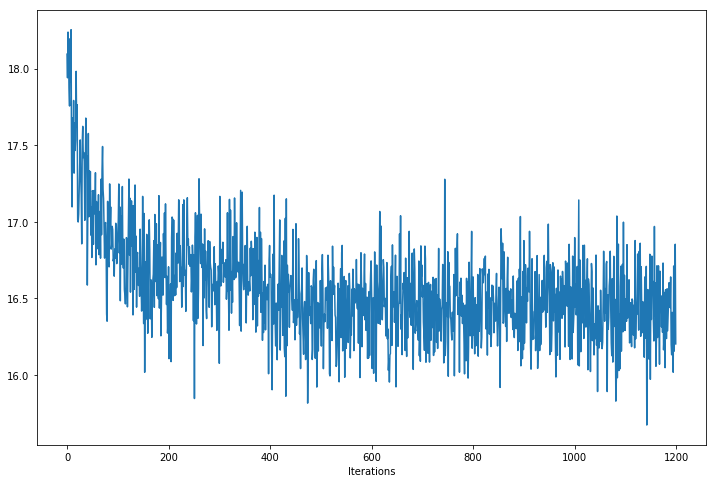

1634.0015592575073 seconds
Alpha: 0.1
Hinge Regularization: -3
Readjustment Interval: 1


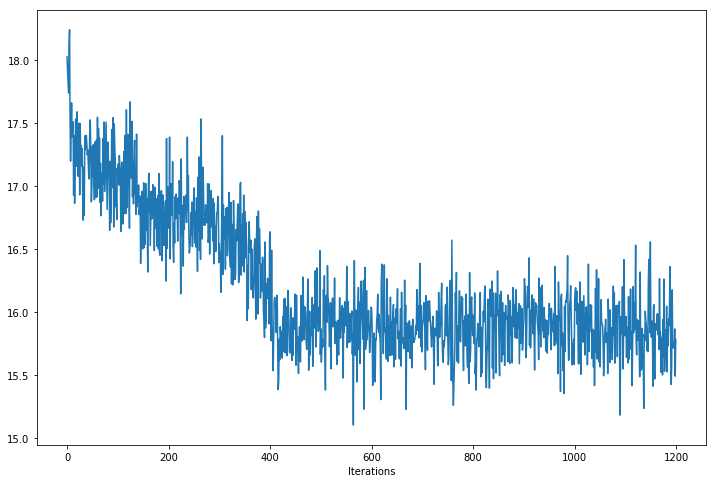

1664.9895792007446 seconds
Alpha: 0.1
Hinge Regularization: -3
Readjustment Interval: 10


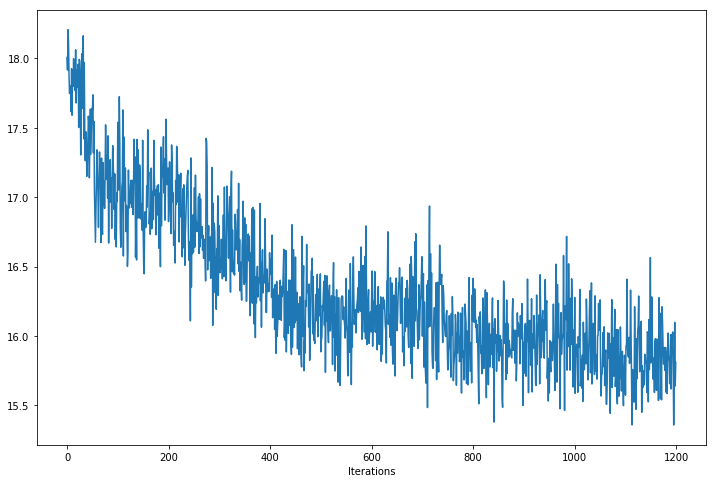

1630.0499000549316 seconds
Alpha: 0.1
Hinge Regularization: -3
Readjustment Interval: 20


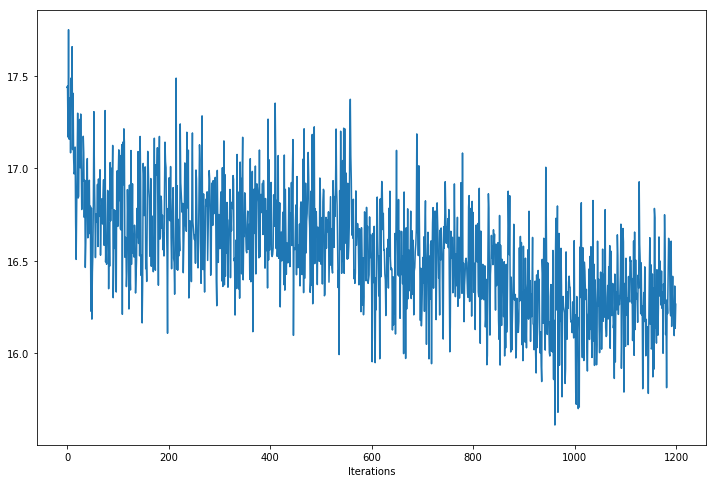

1624.5680766105652 seconds
Alpha: 0.1
Hinge Regularization: -3
Readjustment Interval: 40


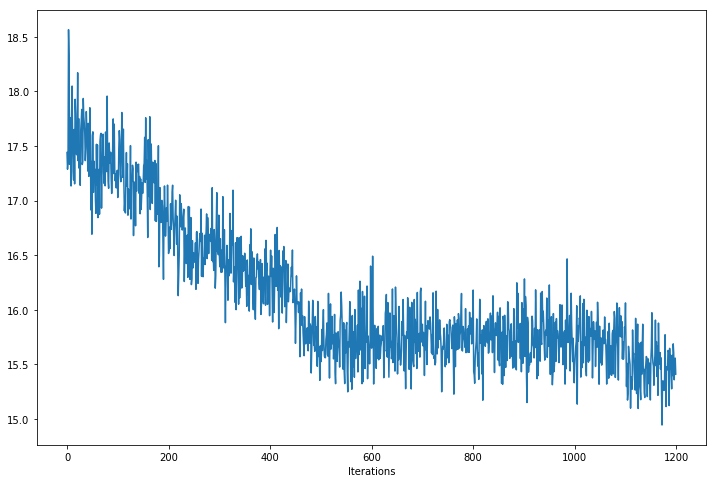

1620.556902885437 seconds
Alpha: 0.1
Hinge Regularization: -2
Readjustment Interval: 1


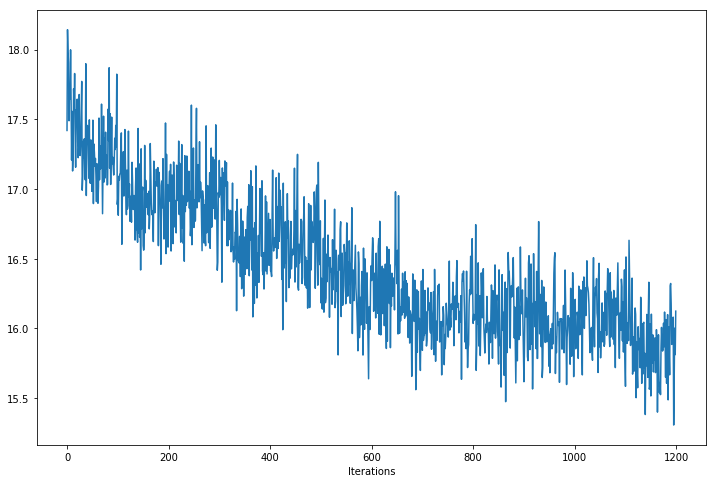

1657.842690229416 seconds
Alpha: 0.1
Hinge Regularization: -2
Readjustment Interval: 10


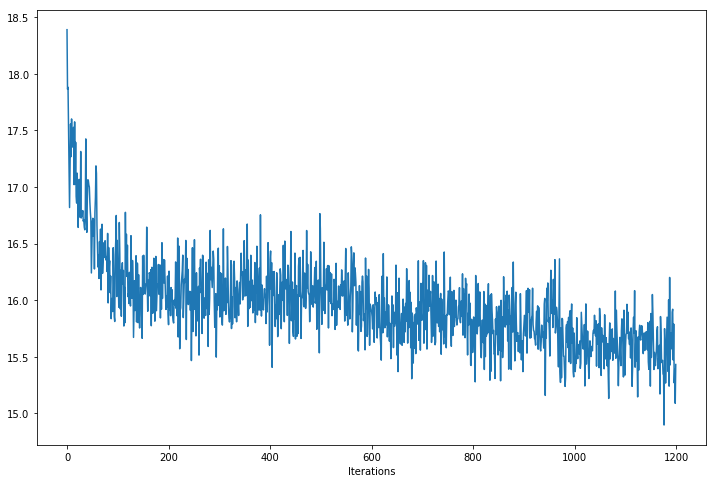

1613.1111409664154 seconds
Alpha: 0.1
Hinge Regularization: -2
Readjustment Interval: 20


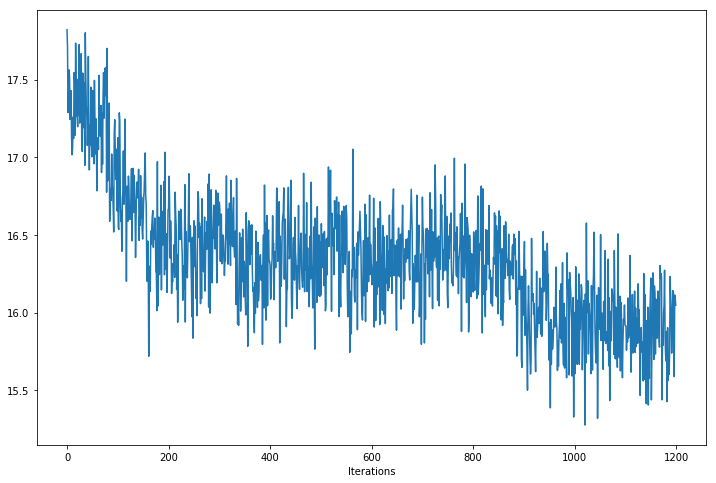

1610.9121334552765 seconds
Alpha: 0.1
Hinge Regularization: -2
Readjustment Interval: 40


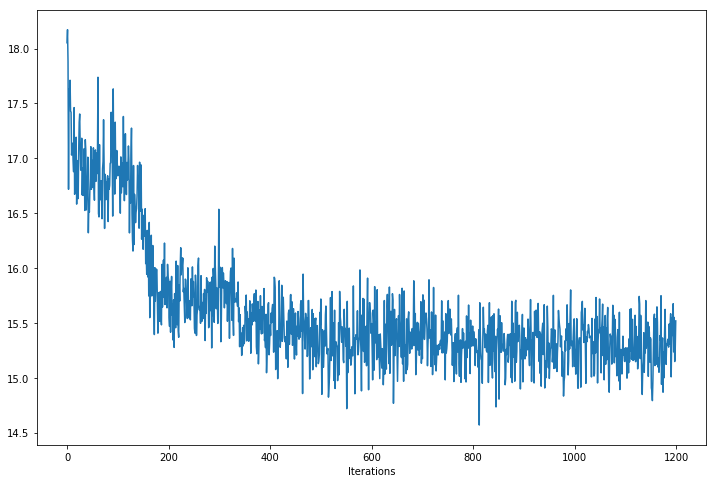

2118.3703253269196 seconds
Alpha: 0.1
Hinge Regularization: -1
Readjustment Interval: 1


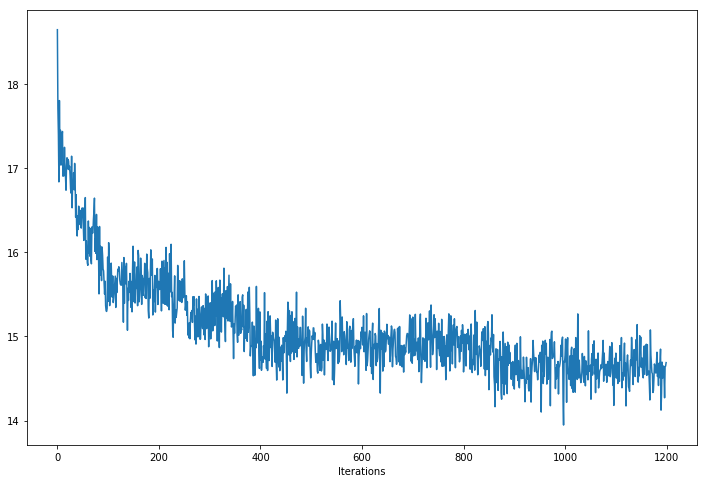

2653.322829246521 seconds
Alpha: 0.1
Hinge Regularization: -1
Readjustment Interval: 10


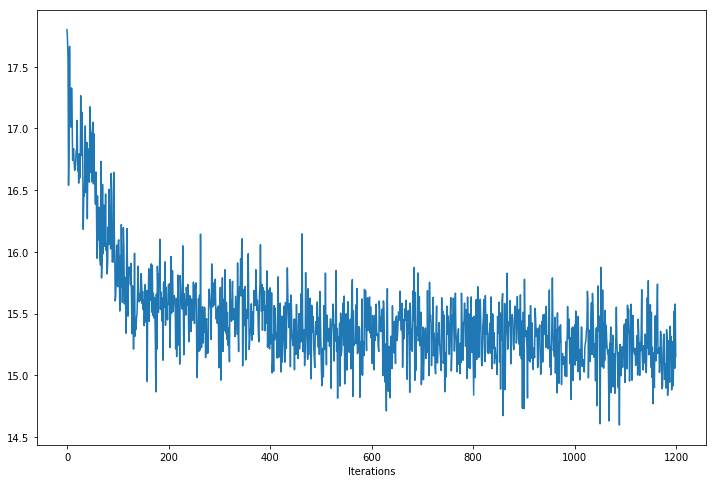

2619.632274389267 seconds
Alpha: 0.1
Hinge Regularization: -1
Readjustment Interval: 20


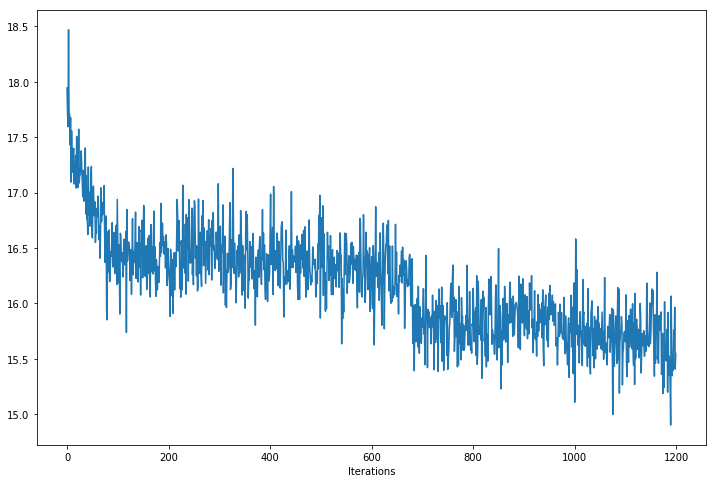

1611.3655638694763 seconds
Alpha: 0.1
Hinge Regularization: -1
Readjustment Interval: 40


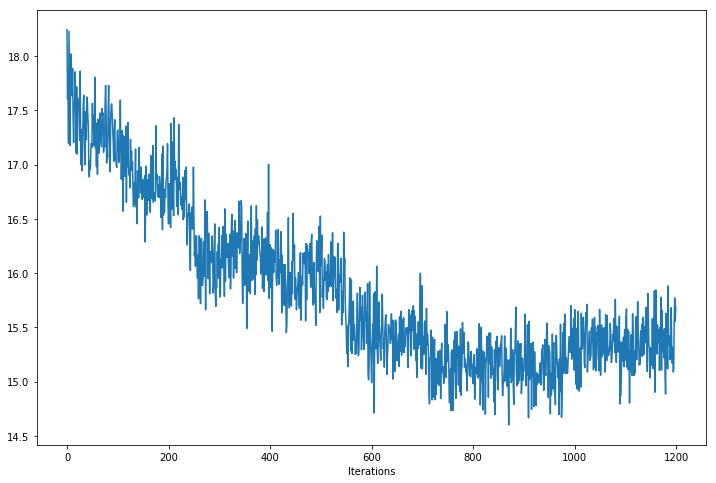

2441.5363924503326 seconds
Alpha: 0.1
Hinge Regularization: 0
Readjustment Interval: 1


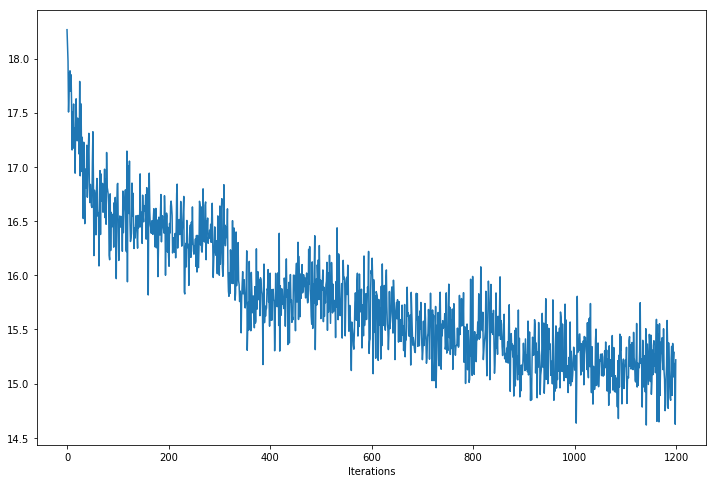

2604.5537197589874 seconds
Alpha: 0.1
Hinge Regularization: 0
Readjustment Interval: 10


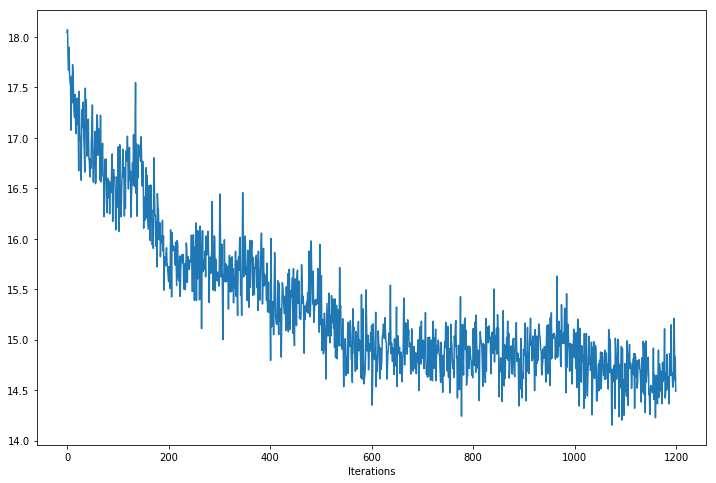

2568.0044548511505 seconds
Alpha: 0.1
Hinge Regularization: 0
Readjustment Interval: 20


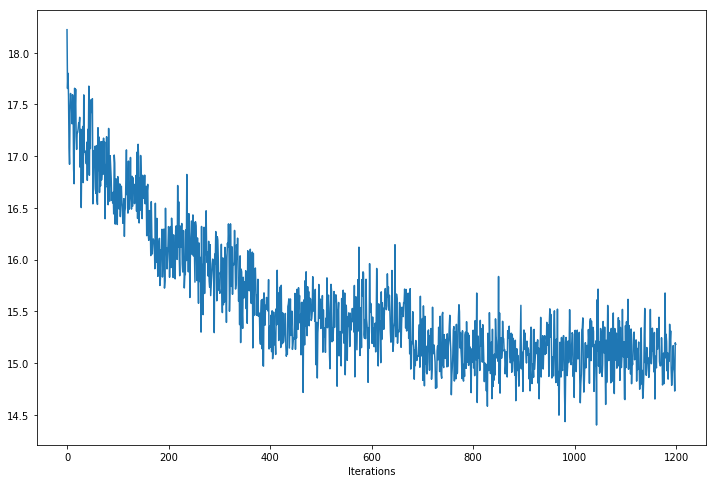

2555.3983066082 seconds
Alpha: 0.1
Hinge Regularization: 0
Readjustment Interval: 40


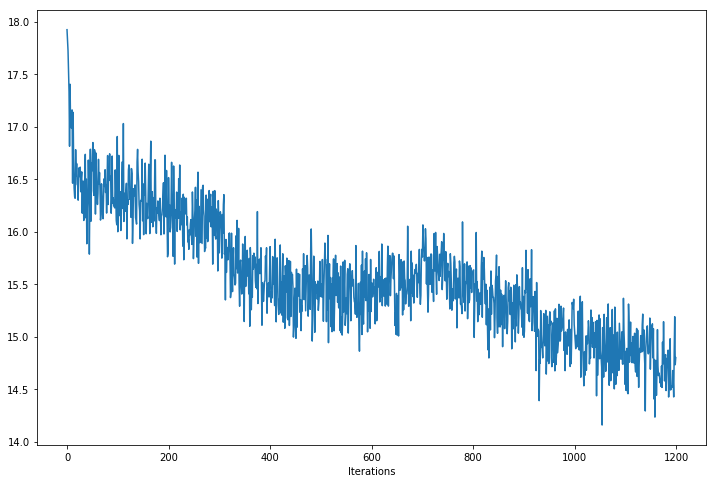

2596.168107509613 seconds
Alpha: 0.1
Hinge Regularization: 1
Readjustment Interval: 1


In [ ]:
for alpha in [0.1,0.01,0.001,0.0001]:
    for hinge_param in range(-5,6):
        for readj_interval in (1,10,20,40):
            print('Alpha:',alpha)
            print('Hinge Regularization:',hinge_param)
            print('Readjustment Interval:',readj_interval)
            optimize(
                T=3,
                alpha=alpha,
                max_iterations=1200,
                batch_size=48,
                test_size=128,
                hinge_param = hinge_param,
                readj_interval=readj_interval,
                gd_algorithm=None
            )

Alpha: 0.1
Hinge Regularization: 1
Readjustment Interval: 1


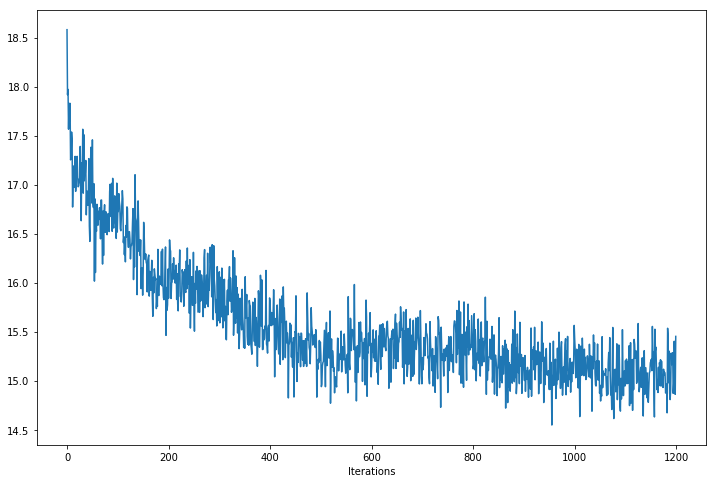

1548.150229215622 seconds
Alpha: 0.1
Hinge Regularization: 1
Readjustment Interval: 10


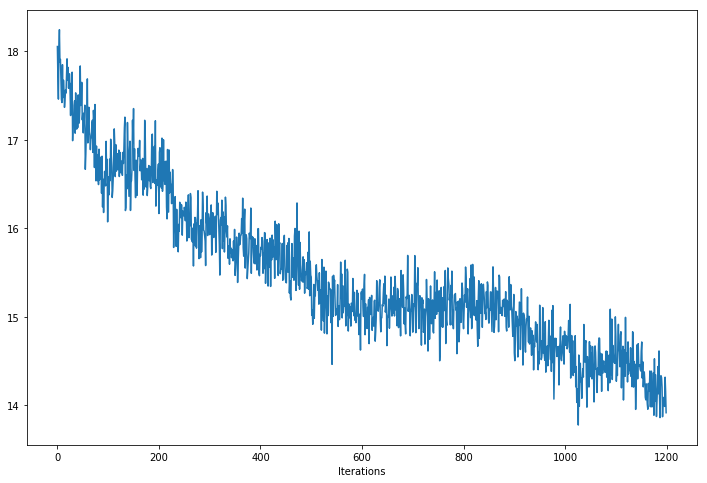

1511.603197813034 seconds
Alpha: 0.1
Hinge Regularization: 1
Readjustment Interval: 20


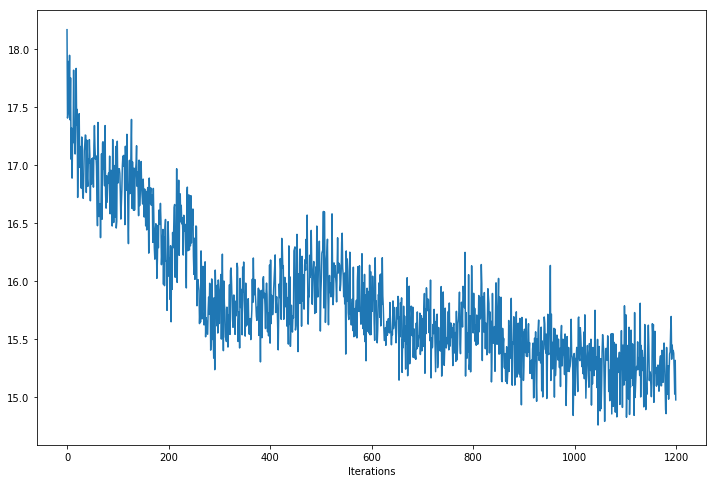

1513.757719039917 seconds
Alpha: 0.1
Hinge Regularization: 1
Readjustment Interval: 40


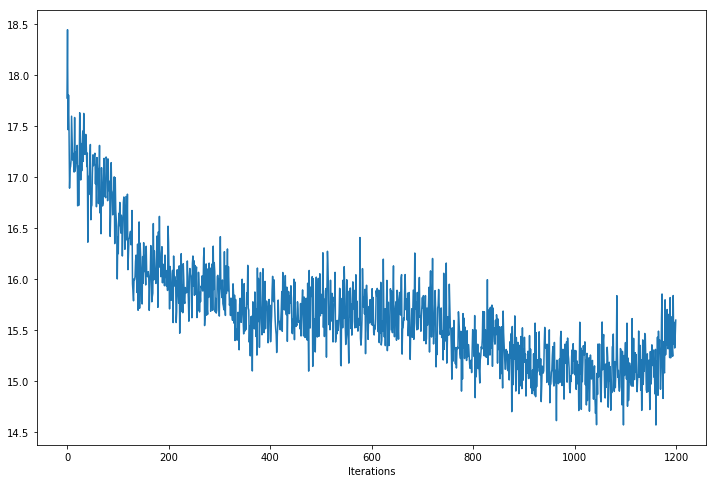

1511.564914226532 seconds
Alpha: 0.1
Hinge Regularization: 2
Readjustment Interval: 1


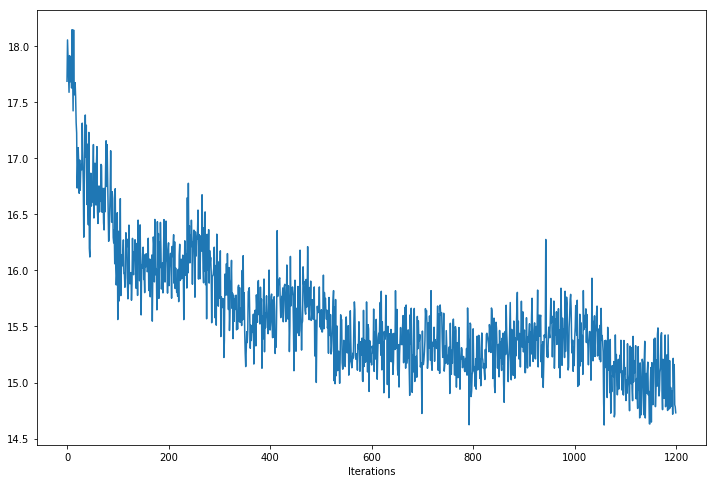

1559.1096801757812 seconds
Alpha: 0.1
Hinge Regularization: 2
Readjustment Interval: 10


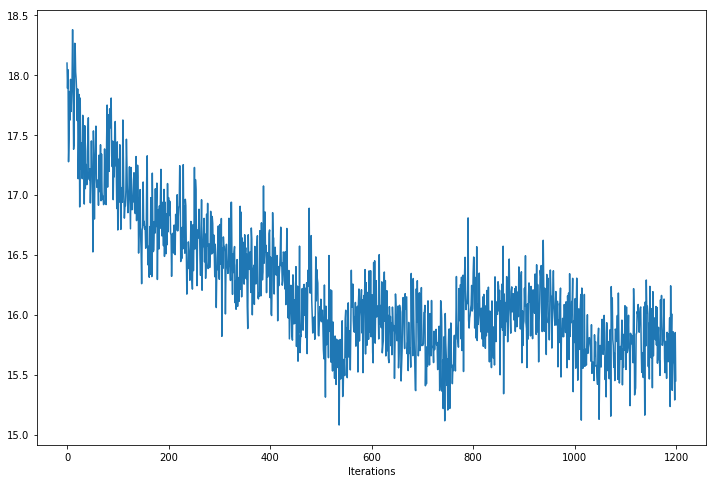

1520.2271254062653 seconds
Alpha: 0.1
Hinge Regularization: 2
Readjustment Interval: 20


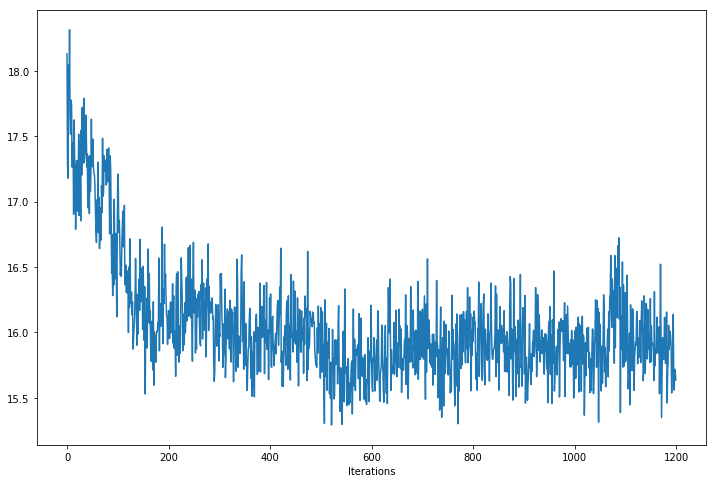

1514.1622369289398 seconds
Alpha: 0.1
Hinge Regularization: 2
Readjustment Interval: 40


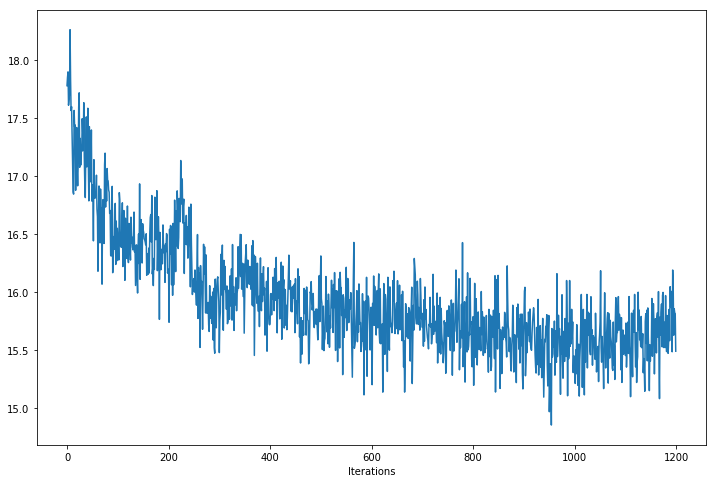

1519.0647246837616 seconds
Alpha: 0.1
Hinge Regularization: 3
Readjustment Interval: 1


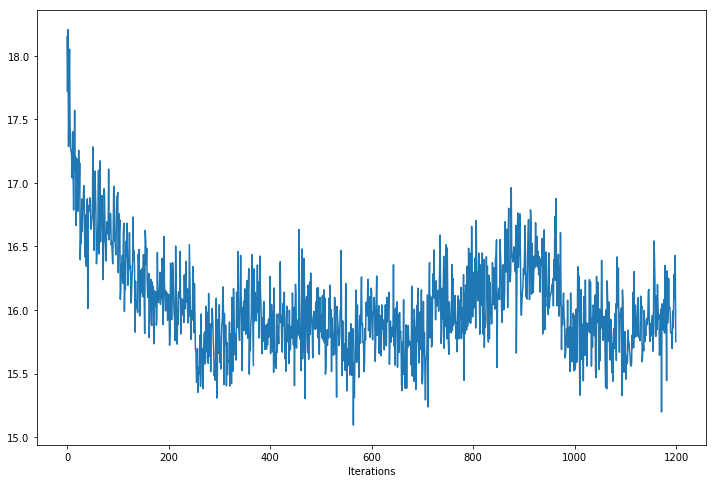

1574.4369730949402 seconds
Alpha: 0.1
Hinge Regularization: 3
Readjustment Interval: 10


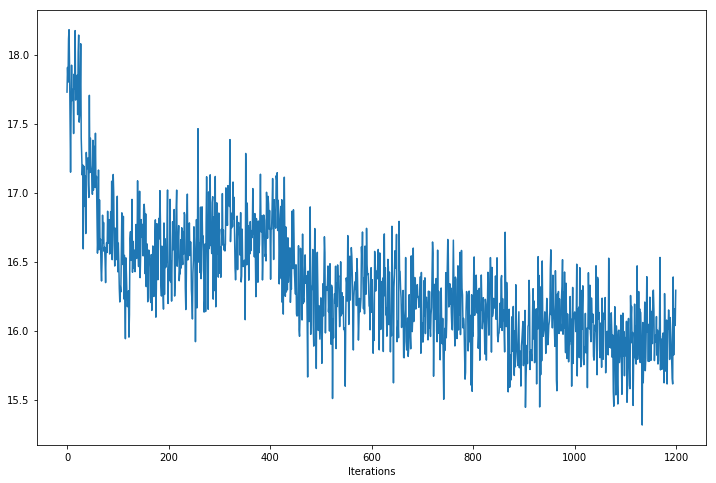

1539.4143991470337 seconds
Alpha: 0.1
Hinge Regularization: 3
Readjustment Interval: 20


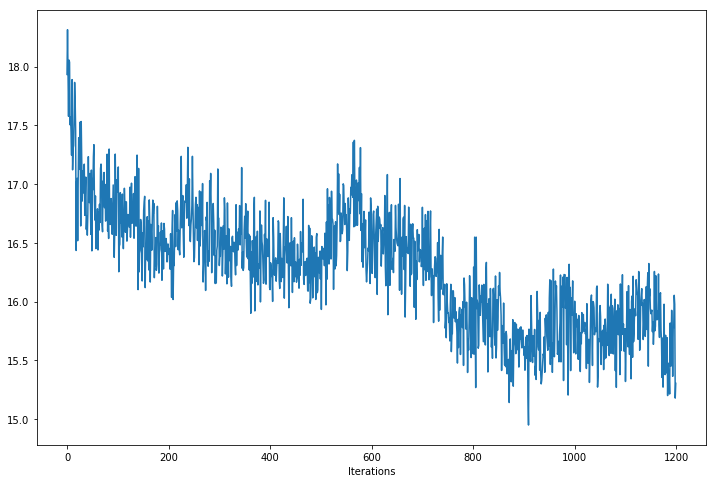

1514.799479484558 seconds
Alpha: 0.1
Hinge Regularization: 3
Readjustment Interval: 40


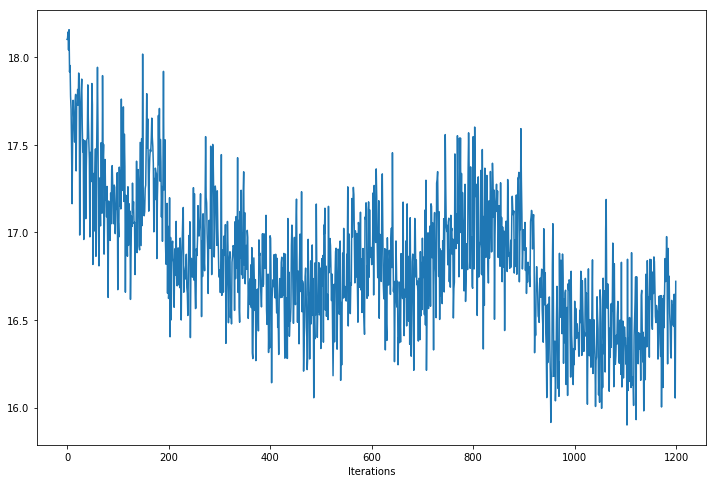

1514.967521429062 seconds
Alpha: 0.1
Hinge Regularization: 4
Readjustment Interval: 1


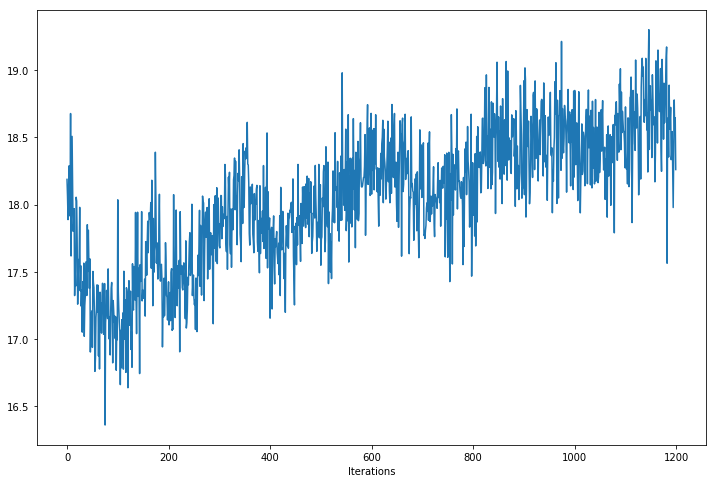

1564.3597769737244 seconds
Alpha: 0.1
Hinge Regularization: 4
Readjustment Interval: 10


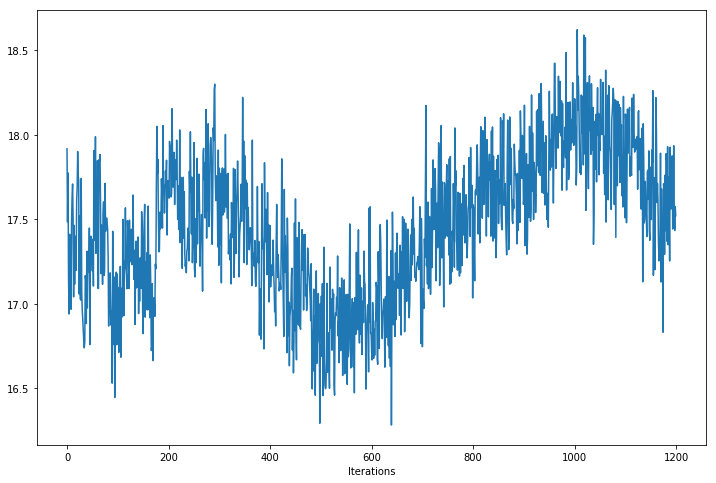

1520.7987303733826 seconds
Alpha: 0.1
Hinge Regularization: 4
Readjustment Interval: 20


KeyboardInterrupt: 

In [ ]:
for hinge_param in range(1,6):
    for readj_interval in (1,10,20,40):
        print('Alpha:',0.1)
        print('Hinge Regularization:',hinge_param)
        print('Readjustment Interval:',readj_interval)
        optimize(
            T=3,
            alpha=0.1,
            max_iterations=1200,
            batch_size=48,
            test_size=128,
            hinge_param = hinge_param,
            readj_interval=readj_interval,
            gd_algorithm=None
        )

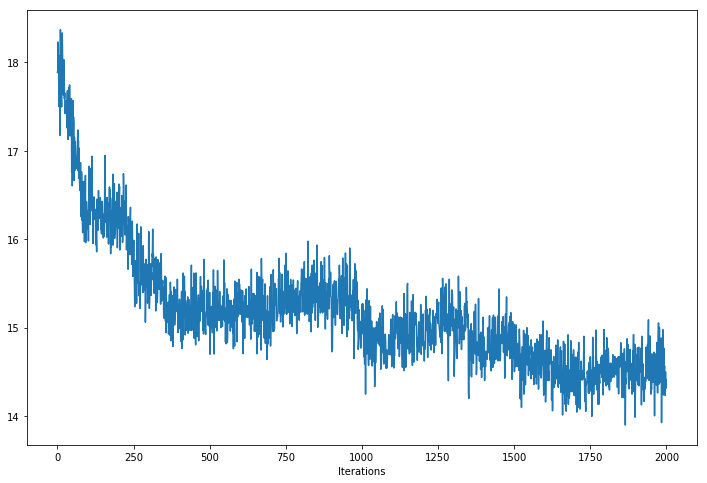

2554.4814302921295 seconds


In [12]:
# Alpha: 0.1
# Hinge Regularization: 1
# Readjustment Interval: 10
optimize(
    T=3,
    alpha=0.1,
    max_iterations=2000,
    batch_size=48,
    test_size=128,
    hinge_param = 1,
    readj_interval=10,
    gd_algorithm=None
)